<a href="https://colab.research.google.com/github/dcolinmorgan/AXA_AE_app/blob/main/DM_TGCN_stellar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting using spatio-temporal data with combined Graph Convolution + LSTM model

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 29.4 MB/s 
     |████████████████████████████████| 482 kB 31.4 MB/s 
     |████████████████████████████████| 41 kB 606 kB/s 


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [40]:
import os,sys,glob
import urllib.request
from geopy.geocoders import Nominatim
import geopy.distance
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

## Loading and preprocessing the data

In [4]:
import stellargraph as sg

This demo is based on the preprocessed version of the dataset used by the TGCN paper.

In [5]:
dataset = sg.datasets.METR_LA()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: METR_LA is experimental: tests and documentation missing (see: https://github.com/stellargraph/stellargraph/issues/1303). It may be difficult to use and may have major changes at any time.
  """Entry point for launching an IPython kernel.


(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [61]:
speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


In [62]:
[speed_data.shape,sensor_dist_adj.shape]

[(207, 2016), (207, 207)]

**Let's look at a sample of speed data.**

In [ ]:
# !wget https://github.com/dcolinmorgan/AXA_AE_app/raw/main/axa_p.zip
# !7z x /content/axa_p.zip
# df2=pd.read_parquet('/content/AE_AXA_dat_full.parquet')

# !git clone https://github.com/dcolinmorgan/aqi-stations-scraper.git

# list_a = ['pneumonia', 'COPD','asthma','resp','lung','pulm']#,'~Cancer']
# list_b = ['Cancer']
df2.columns=['pat_id','cd9_loc','sess','sex','age','cd9_code','mini_loc','loc1','date','tmp','diag1','diag2','tmp']

# df2=df[df['diag1'].isin(list_a)]
# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

# df.diag1, df.diag2 = np.where(df.diag1.str.contains('None'), [df.diag2, df.diag1], [df.diag1, df.diag2])
# del df['sess'], df['tmp'], df['diag2']
# df=df[~df['diag1'].isna()]

# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

df2.replace({'RH':'Ruttonjee Hospital'},inplace=True)
df2.replace({'PYN':'Pamela Youde Nethersole Eastern Hospital'},inplace=True)
df2.replace({'QEH':'Queen Elizabeth Hospital'},inplace=True)
df2.replace({'CMC':'Caritas Medical Centre'},inplace=True)
df2.replace({'KWH':'Kwong Wah Hospital'},inplace=True)
df2.replace({'TMH':'Tuen Mun Hospital'},inplace=True)
df2.replace({'PWH':'Prince of Wales Hospital'},inplace=True)
df2.replace({'NDH':'North District Hospital'},inplace=True)
df2.replace({'YCH':'Yan Chai Hospital'},inplace=True)
df2.replace({'UCH':'United Christian Hospital'},inplace=True)
df2.replace({'QMH':'Queen Mary Hospital'},inplace=True)
df2.replace({'PWH':'Princess Margaret Hospital'},inplace=True)
df2.replace({'POH':'Pok Oi Hospital'},inplace=True)
df2.replace({'TKO':'Tseung Kwan O Hospital'},inplace=True)
df2.replace({'AHN':'Alice Ho Miu Ling Nethersole Hospital'},inplace=True)
df2.replace({'SJH':'St. John Hospital'},inplace=True)
df2.replace({'NLT':'North Lantau Hospital'},inplace=True)
df2.replace({'TSH':'Tang Shiu Kin Hospital'},inplace=True)
df2.replace({'PMH':'Princess Margaret Hospital'},inplace=True)


#organize
cc=pd.DataFrame()#(columns=['date','pm25','pm10','o3','no2','so2','co','loc'])
files=glob.glob('/content/aqi-stations-scraper/data/japan-aqi/*')
for file in files:
    data=pd.read_csv(file,sep=' |,')
    data['loc1']=os.path.basename(file).split(',')[0]
    cc=cc.append(data)

data2=cc[['date','pm25','pm10','o3','no2','so2','co','loc1']]
data2['loc1']=data2['loc1'].str.upper().replace({'-':' '},regex=True)
data2['date']=pd.to_datetime(data2['date'])

geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(df2['cd9_loc'])):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]


data2.replace('CENTRALNAYA STR','central',inplace=True)
data2.replace('SOUTHERN','southern island',inplace=True)
data2.replace('SOUTHERN PART OF CHENGYANG DISTRICT','chengyang district',inplace=True)

data_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(data2['loc1'])):
    try:
        a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    except AttributeError:
        print('no location data for: '+str(i))
    data_loc[ii]=[a,b,i]
data_loc=data_loc.transpose()
data_loc.columns=['lat','long','name']
data_loc=data_loc[3:]

data_loc=data_loc[~data_loc.duplicated(['lat','long'],keep='first')]
data_loc.reset_index(inplace=True)

data_loc=df_loc.append(data_loc)[['lat','long','name']]
2
data_loc.reset_index(inplace=True)


# geopy DOES use latlon configuration
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))
square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)

# replacing distance.vicenty with distance.distance
def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )

distances = square.apply(get_distance, axis=1).T

data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
D_D=pd.DataFrame((distances<5)*1)
D_D.index=data_loc['src']
D_D.columns=data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
E_E.reset_index(inplace=True)#
distance_mat=E_E[E_E[0]>0]

distance=distances
distance.index=data_loc['src']
distance.columns=data_loc['dst']
distance=pd.DataFrame(distance.stack())
distance.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)

distances.to_numpy()

In [65]:
speed_data=(df2.pivot_table(values='diag1', index='date', columns='cd9_loc', aggfunc='count').fillna(0).values)
speed_data=(np.repeat(speed_data,2,axis=1))
speed_data=pd.DataFrame(speed_data[:,:-1].T)
sensor_dist_adj=distances
[speed_data.shape,sensor_dist_adj.shape]

[(35, 3502), (35, 35)]

As you can see above, there are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes.  This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207  for 7 days (12X24X7).

### Forecasting with spatio-temporal data as a supervised learning problem 

Time series forecasting problem can be cast as a supervised learning problem. We can do this by using previous timesteps as input features and use the next timestep as the output to predict. Then, the spatio-temporal forecasting question can be modeled as predicting the feature value in the future, given the historical values of the feature for that entity  as well as the feature values of the entities "connected" to the entity.  For example, the speed prediction problem, the historical speeds of the sensors are the timeseries and the distance between the sensors is the indicator for connectivity or closeness of sensors.

### Train/test split

Just like for modeling any standard supervised learning problem, we first split the data into mutually exclusive train and test sets. However, unlike, a standard supervised learning problem,  in timeseries analysis, the data is in some chronological time respecting order and the train/test happens along the timeline. Lets say, we use the first `T_t` observations for training and the remaining `T - T_t` of the  total `T` observations for testing.  

In the following we use first 80% observations for training and the rest for testing.

In [66]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [67]:
train_rate = 0.8

In [69]:
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (35, 2801)
Test data:  (35, 701)


### Scaling
It is generally a good practice to  rescale the data from the original range so that all values are within the range of 0 and 1. Normalization can be useful and even necessary when your time series data has input values with differing scales.  In the following we normalize the speed timeseries by the maximum and minimum values of speeds in the train data. 

Note: `MinMaxScaler` in `scikit learn` library is typically used for transforming data. However, in timeseries data since the features are distinct timesteps, so using the historical range of values in a particular timestep as the range of values in later timesteps, may not be correct.  Hence, we use the maximum and the minimum of the entire range of values in the timeseries to scale and transform the train and test sets respectively.

In [70]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [71]:
train_scaled, test_scaled = scale_data(train_data, test_data)

### Sequence data preparation for LSTM

We first need to prepare the data to be fed into an LSTM. 
The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

To make it concrete in terms of the speed prediction problem, we choose to use 50 minutes of historical speed observations to predict the speed in future, lets say, 1 hour ahead. Hence, we would first  reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:  

* Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict. 
* Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict. 
* Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.
* The above steps are done for each sensor. 

The function below returns the above transformed timeseries data for the model to train on. The parameter `seq_len` is the size of the past window of information. The `pre_len` is how far in the future does the model need to learn to predict. 

For this demo: 

* Each training observation are 10 historical speeds (`seq_len`).
* Each training prediction is the speed 60 minutes later (`pre_len`).

In [72]:
seq_len = 10
pre_len = 12

In [73]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [74]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2780, 35, 10)
(2780, 35)
(680, 35, 10)
(680, 35)


## StellarGraph Graph Convolution and LSTM model

In [75]:
from stellargraph.layer import GCN_LSTM

In [76]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


In [77]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [78]:
model = Model(inputs=x_input, outputs=x_output)

In [79]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [80]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)

In [81]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 35, 10)]          0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 35, 10, 1)        0         
 a)                                                              
                                                                 
 reshape_3 (Reshape)         (None, 35, 10)            0         
                                                                 
 fixed_adjacency_graph_convo  (None, 35, 16)           1420      
 lution_2 (FixedAdjacencyGra                                     
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_convo  (None, 35, 10)           1420      
 lution_3 (FixedAdjacencyGra                               

In [82]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.05664994940161705 
Test loss: 0.06071401387453079


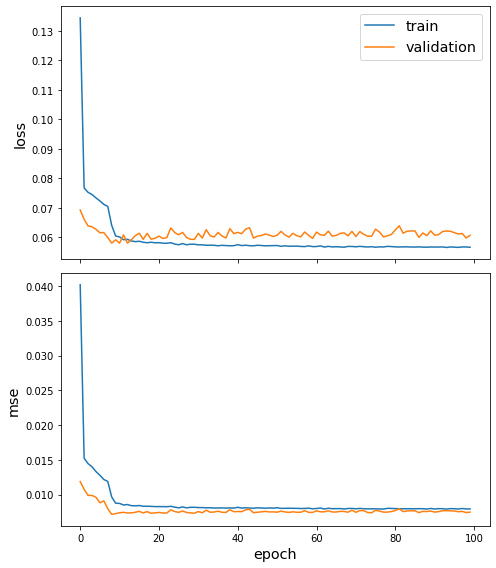

In [83]:
sg.utils.plot_history(history)

In [84]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

## Rescale values

Rescale the predicted values to the original value range of the timeseries.

In [85]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [86]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

## Measuring the performance of the model

To understand how well the model is performing, we compare it against a naive benchmark.

1. Naive prediction: using the most recently **observed** value as the predicted value. Note, that albeit being **naive** this is a very strong baseline to beat. Especially, when speeds are recorded at a 5 minutes granularity,  one does not expect many drastic changes within such a short period of time. Hence, for short-term predictions naive is a reasonable good guess.

### Naive prediction benchmark (using latest observed value)

In [87]:
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [88]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 0.8416013151363136
Total (ave) MAE for naive prediction: 1.0494117647058825
Total (ave) MASE for per-segment NN/naive MAE: 0.7808631147268134
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


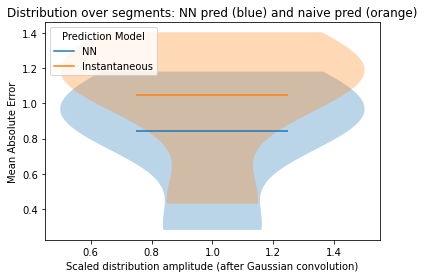

In [89]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

#### Plot of actual and predicted speeds on a sample sensor

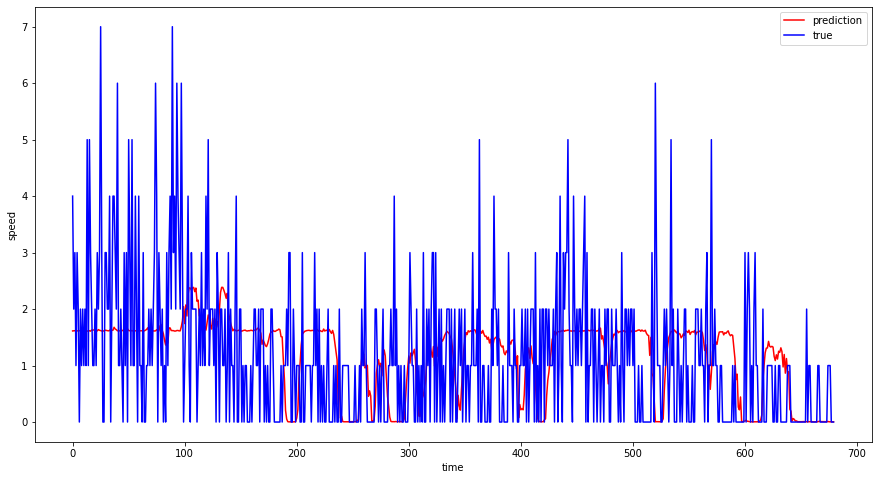

In [91]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 10]
a_true = test_rescref[:, 10]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>